# Image Classification with Keras

Source: https://gitlab.com/ecostat/imaginecology/-/tree/master/projects/classifierWithKeras/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Keras and Tensorflow are also required.

## Setup of the model

We first load the architecture MobileNet and its weights. MobileNet is a CNN architecture that we will use as a feature extractor. As it has been trained on 
[ImageNet](https://www.image-net.org/), we will retrain the classifier part with our own data. To do so, we remove the head layer of the network.

The pictures will be of a size 299 pixel x 299 pixel , and are using the RGB color space (3 dimensions).

In [2]:
from keras.applications.mobilenet import MobileNet, preprocess_input

base_model = MobileNet(include_top=False, weights="imagenet", input_shape=(299, 299, 3))

Now that the weights are loaded and the head cut, we add our own classifier. We use a dense layer with 2 neurons, and a softmax activation function.

In [3]:
from keras.layers import Dense, GlobalAveragePooling2D, Activation

x = base_model.output
print("Output shape :", x.shape)
x = GlobalAveragePooling2D()(x)
print("Network shape after Global Pooling :", x.shape)
x = Dense(512)(x)
x = Dense(17)(x)
preds = Activation("softmax")(x)

Output shape : (None, 9, 9, 1024)
Network shape after Global Pooling : (None, 1024)


The model is then compiled and trained using the following code:

In [4]:
from keras.models import Model

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

The sgd refers to stochastic gradient descent. The gradient is approximated using subset of the data (batchs). It results in faster iterations but the loss function is not as well minimized.

The categorical crossentropy is written as follows: 
$ - \sum_{i=1}^{K} y_i \log(p_i) $ where $y_i$ is 1 if it is the good label, 0 else, and $p_i$ the predicted probability for the class $i$, among the $K$ classes.

## Loading the data

For sake of simplicity, we use an object that will tackle the data augmentation for us, but also the loading of the data. The data is loaded from the folder `data` and the subfolders `train` and `test`. The data is split in two parts: the training set and the test set. The training set is used to train the model, and the test set is used to evaluate the model. The test set is not used during the training process.

Data augmentation is a trick to increase the number of images in the training set by applying random transformations to the original images. This helps the model generalize better to and thus reduce overfitting.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,  # will flip images horizontally
    rotation_range=10,  # will rotate images in the range +/- 10 degrees
)

The images are already labeled in separate folders, so we can directly use the following methods to our data generator object.

In [6]:
batch_size = 32

train_generator = data_generator.flow_from_directory(
    directory="Flowers/",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(299, 299),
    subset="training",
)

validation_generator = data_generator.flow_from_directory(
    directory="Flowers/",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(299, 299),
    subset="validation",
)

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


## Model Training

## Saving weights

To save the model weights after each epoch we use a callback. A callback is a function that is called at the end of each epoch. Here we use the ModelCheckpoint callback to save the weights after each epoch, if the validation loss has improved.

In [10]:
from keras.callbacks import ModelCheckpoint

weightpath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath=weightpath, save_best_only=True)

The fit method takes about 40 minutes to run on my computer. To avoid having to run it again, we save the weights in a file, but also the history of the training. The history is a dictionary containing the loss and accuracy on the training and validation sets after each epoch. We can then plot the loss and accuracy curves.

In [11]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8,
    callbacks=[checkpoint],
)

Epoch 1/8
34/34 [==============================] - ETA: 0s - loss: 1.3432 - accuracy: 0.6360

c:\Users\Jules\miniconda3\envs\fidle-env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 292s 9s/step - loss: 1.3432 - accuracy: 0.6360 - val_loss: 0.9833 - val_accuracy: 0.7206
Epoch 2/8
34/34 [==============================] - 289s 8s/step - loss: 0.3124 - accuracy: 0.9412 - val_loss: 0.5789 - val_accuracy: 0.8787
Epoch 3/8
34/34 [==============================] - 282s 8s/step - loss: 0.1693 - accuracy: 0.9761 - val_loss: 0.4373 - val_accuracy: 0.8750
Epoch 4/8
34/34 [==============================] - 274s 8s/step - loss: 0.1037 - accuracy: 0.9908 - val_loss: 0.3784 - val_accuracy: 0.9044
Epoch 5/8
34/34 [==============================] - 286s 8s/step - loss: 0.0753 - accuracy: 0.9926 - val_loss: 0.3098 - val_accuracy: 0.9228
Epoch 6/8
34/34 [==============================] - 288s 8s/step - loss: 0.0556 - accuracy: 0.9972 - val_loss: 0.2717 - val_accuracy: 0.9301
Epoch 7/8
34/34 [==============================] - 288s 8s/step - loss: 0.0425 - accuracy: 0.9991 - val_loss: 0.2560 - val_accuracy: 0.9338
Epoch 8/8
34/34 [=============

In [13]:
np.save("history.npy", history.history)

## Model prediction

In [7]:
history_dict = np.load("history.npy", allow_pickle=True).item()

In [8]:
model.load_weights("weights.hdf5")

By now, we can predict the class of an image using the predict method. The predict method returns a vector of probabilities for each class. The class with the highest probability is the predicted class. The probability is actually the result of the softmax function applied to the output of the last layer of the network. The softmax function is defined as follows: $$\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$ where $z$ is the output of the last layer of the network, and $K$ is the number of classes. 

In [9]:
from keras.preprocessing import image

labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
print(labels)


def predict(filename, top=1):
    """
    Predict the class of an image using the trained model
    Display the image and the predicted class
    Display the top five predictions
    """
    # --- Prediction ---

    img = image.load_img(filename, target_size=(299, 299))  # load image
    x = image.img_to_array(img)  # convert it to array
    x = np.expand_dims(x, axis=0)  # simulate batch dimension
    x = preprocess_input(x)  # preprocessing
    pred = model.predict(x)  # classes prediction

    # --- Plotting ---

    # Get the indices of the top five predictions
    top_indices = (
        pred[0].argsort()[-top:][::-1].tolist()
    )  # because pred is a nested list

    # Create subplots for predicted and actual images
    plt.figure(figsize=(5, 3))

    # Display the predicted image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Actual Class")
    plt.axis("off")

    # Display the first image from the predicted class
    class_images = train_generator.filepaths
    random.shuffle(class_images)  # Trick to avoid displaying the same image every time
    plt.subplot(1, 2, 2)
    for i in class_images:
        if i.startswith("Flowers/" + labels[top_indices[0]]):
            img_actual = image.load_img(i, target_size=(299, 299))
            plt.imshow(img_actual)
            plt.title("Predicted Class")
            plt.axis("off")
            break

    # Put the title below the image
    plt.suptitle(
        f"The predicted class is {labels[top_indices[0]]} with a confidence of {round(100 * pred[0, top_indices[0]], 1)}%"
    )
    plt.tight_layout()
    plt.show()

    # --- Print the top five predictions ---

    print("Top 5 predicted classes:")
    for i in top_indices:
        class_pred = labels[i]
        conf = pred[0, i]
        print(f"Class: {class_pred} - Confidence: {round(100 * conf, 1)}%")

{0: 'Bluebell', 1: 'Buttercup', 2: 'Colts Foot', 3: 'Cowslip', 4: 'Crocus', 5: 'Daffodil', 6: 'Daisy', 7: 'Dandellion', 8: 'Fritillary', 9: 'Iris', 10: 'Lily Valley', 11: 'Pansy', 12: 'Snowdrop', 13: 'Sunflower', 14: 'Tiger Lily', 15: 'Tulip', 16: 'Windflower'}


In [10]:
def plot_class(class_name):
    """
    Plot an image of a specific class
    """
    class_images = train_generator.filepaths
    random.shuffle(
        class_images
    )  # shuffle the images so that we can get different images each time
    for i in class_images:
        if i.startswith("Flowers/" + class_name):
            img = image.load_img(i, target_size=(299, 299))
            plt.figure(figsize=(2, 2))
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
            plt.show()
            break

1/1 [==============================] - 2s 2s/step


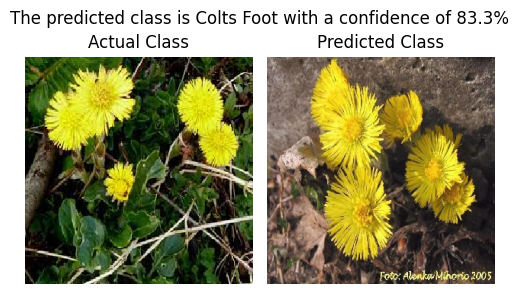

Top 5 predicted classes:
Class: Colts Foot - Confidence: 83.3%
Class: Dandellion - Confidence: 15.3%
Class: Sunflower - Confidence: 0.4%
Class: Daisy - Confidence: 0.3%
Class: Crocus - Confidence: 0.2%


In [11]:
# Select a random image from the Test folder
import random
import os

test_images = os.listdir("Test/")
img = random.choice(test_images)

l = predict("Test/" + img, 5)

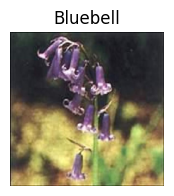

In [128]:
plot_class("Bluebell")

In [112]:
def plot_history_metrics(history):
    """
    Plot the accuracy and loss curves for the training and validation sets

    Warning: The history object must be a dictionary with the accuracy as one of its keys
    not the history object returned by model.fit()
    """
    plt.figure(figsize=(10, 5))

    # ---- Accuracy ----
    plt.subplot(1, 2, 1)
    acc = history["accuracy"]
    val_acc = history["val_accuracy"]
    epochs = range(len(acc))

    plt.plot(epochs, acc, "b", label="Training accuracy")
    plt.plot(epochs, val_acc, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # ---- Loss ----
    plt.subplot(1, 2, 2)
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(len(loss))

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # ---- Show plot ----

    plt.tight_layout()
    plt.show()

With 8 epochs, we don't see yet a clear overfitting. The validation loss is still decreasing, and the validation accuracy is still increasing. We could train the model for more epochs, but as it takes a long time, we will stop here. Furthermore the rate of improvement is decreasing which could indicate that the model might soon overfit.

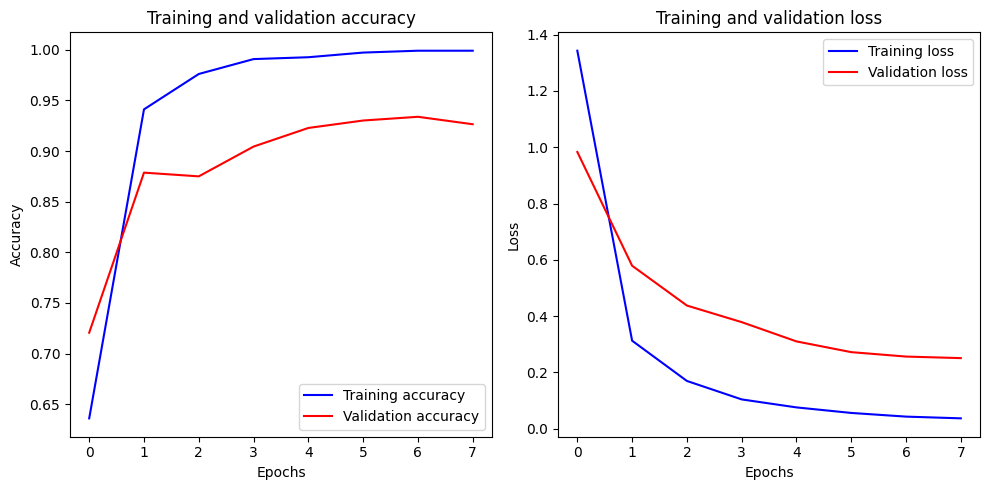

In [113]:
plot_history_metrics(history_dict)